# TO DO
## Download file from https://drive.google.com/drive/folders/1ryQu-VBk5Hw77f_Ep7QH0exbVw4p7xtr?usp=share_link
## Upload to your drive 



In [ ]:
%matplotlib inline
!pip install jmd_imagescraper --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.1 MB/s eta 0:00:00


In [ ]:
from fastai.vision.all import *
from fastai.vision.gan import *

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content'

In [ ]:
os.chdir('/content/drive/MyDrive')


## data

For this lesson, we'll be using the bedrooms from the [LSUN dataset](http://lsun.cs.princeton.edu/2017/). The full dataset is a bit too large so we'll use a sample from [kaggle](https://www.kaggle.com/jhoward/lsun_bedroom).
Alternatively you can create your own data or use a different dataset PET

In [ ]:
option = 'default' # chose between default - room or custom or PET
prompt = "lions" # for custom only - specify what to search for 
if option == 'custom':
  num_imgs = 10
  folder_name = "folder_name"
  from jmd_imagescraper.core import * # dont't worry, it's designed to work with import *
  from pathlib import Path
  root = Path().cwd()/"images"/folder_name
  duckduckgo_search(root, folder_name, prompt , max_results=num_imgs)
  path = root # use custom data
  print('using CUSTOM')
elif option == 'pet':
  print('using PET')
  path = untar_data(URLs.PETS)/'images'
else:
  path = untar_data(URLs.LSUN_BEDROOMS)
  print('using ROOM')


using ROOM


We then grab all the images in the folder with the data block API. We don't create a validation set here for reasons we'll explain later. It consists of random noise of size 100 by default (can be changed if you replace `generate_noise` by `partial(generate_noise, size=...)`) as inputs and the images of bedrooms as targets.

In [ ]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop),
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
    return dblock.dataloaders(path, path=path, bs=bs)

We'll begin with a small size since GANs take a lot of time to train.

In [ ]:
dls = get_dls(16, 64)

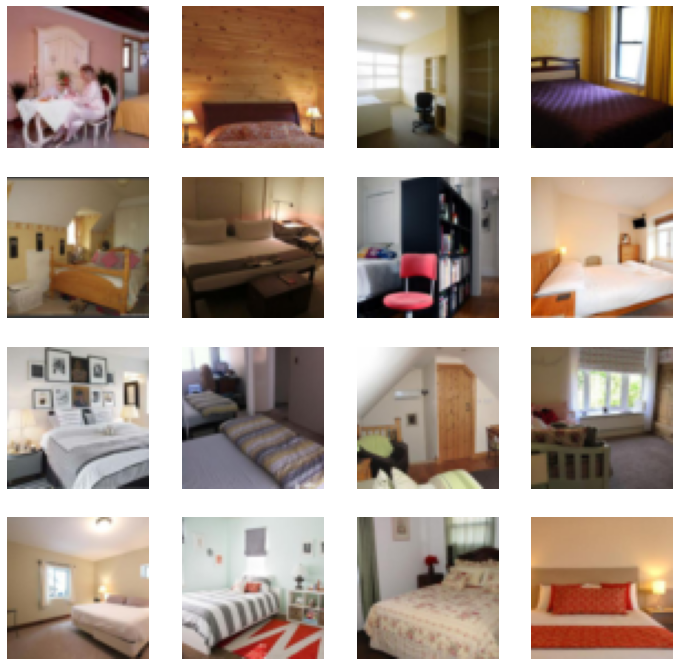

In [ ]:
dls.show_batch(max_n=16)

## Models

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in our dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:
1. Freeze the generator and train the critic for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the critic with the gradients of this loss
  
  
2. Freeze the critic and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the critic on it
  - return a loss that rewards positively the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the generator with the gradients of this loss
  
Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

We create a generator and a critic that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.

In [ ]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [ ]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = partial(Adam, mom=0.))
try:
  learn.load(os.getcwd()+'/save_folder/roomGAN')
  learn.gan_trainer.switch(gen_mode=True)
  learn.show_results(max_n=16, figsize=(8,8), ds_idx=0)
except:
  print('Could not load - have you upload data to your drive ?')

In [ ]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [ ]:
# Start training - take quite long though so feel free to test it at home
learn.fit(3, 2e-4, wd=0)

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


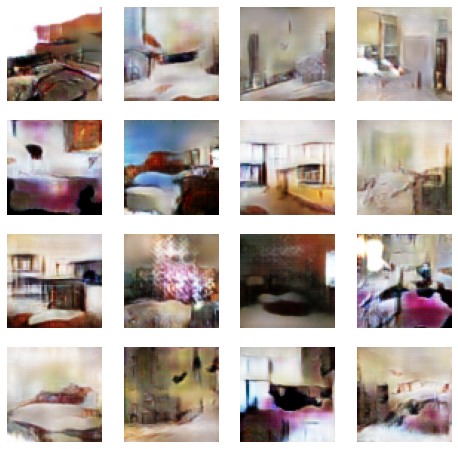

In [ ]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(max_n=16, figsize=(8,8), ds_idx=0)

In [ ]:
learn.save(os.getcwd()+'/save_folder/roomGAN')


Path('/content/roomGAN.pth')